In [14]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("../utils/")
# from res_processing_utils import get_ave_metric, running_mean
from res_processing_utils import *
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
from plot_utils import save_csv, save_csv_only_y
from plot_utils import get_config_with_best_train_loss, get_config_with_best_test_acc
from plot_utils import plot_test_acc, plot_train_loss
from plot_utils import plot_best_config_multiple_epochs
from plot_utils import plot_best_config_fixed_epochs, plot_best_config_fixed_epochs

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
top_directory = "/dfs/scratch0/zjian/floating_halp/exp_res/lstm_dec_24_conll2000/"
pattern = "opt_sgd_momentum_0.0_lr_0.5_l2_reg_0.0001_"
train_loss = get_ave_metric(pattern, top_directory, seed_list=[1,], metric="train_loss")
test_loss = get_ave_metric(pattern, top_directory, seed_list=[1,], metric="test_loss")
test_acc = get_ave_metric(pattern, top_directory, seed_list=[1,], metric="test_acc")
grad_norm = get_ave_metric(pattern, top_directory, seed_list=[1,], metric="grad_norm")

In [16]:
train_loss.shape, test_loss.shape, test_acc.shape, grad_norm.shape

((55800,), (100,), (100,), (55800,))

In [17]:
train_loss[-1], test_loss[-1], test_acc[-1], grad_norm[-1]

(0.3201169972658158,
 0.25886011440912343,
 0.9585066949088433,
 0.2700388891854503)

In [18]:
def plot_train_loss(label_list, train_loss_list):
    plt.figure()
    data_list = []
    for train_loss, label in zip(train_loss_list, label_list):
        data_list.append((label, np.arange(train_loss.size) + 1, train_loss))
        plt.semilogy(np.minimum.accumulate(train_loss), label=label)
#         plt.semilogy(train_loss, label=label)
    plt.legend()
#     plt.ylim([None, 1e-1])
    plt.xlabel("Iterations")
    plt.ylabel("Training loss")
#     plt.title("CIFAR10 (LeNet)")
    plt.grid()
    plt.show()
#     save_csv(data_list, file_name="./workspace/lenet_train_loss_all.csv")


In [20]:
# this is the same as in the unified version
def plot_best_config_fixed_epochs(cut_off_epoch=100, total_epoch=100, 
                                  win_width=1000, 
                                  top_directory = "/dfs/scratch0/zjian/floating_halp/exp_res/lenet_hyper_sweep_2018_nov_17/", 
                                  epoch_len=391,
                                  seed_list=[1, 2, 3], 
                                  pattern_list_array=[ ["_bc-svrg",], 
                                                      ["_lp-svrg",],
                                                      ["_svrg",],
                                                      ["_bc-sgd",],
                                                      ["_lp-sgd",],
                                                      ["_sgd",]],
                                  plot_label_list=["halp", "svrg (16)", "svrg (32)", "bc-sgd (16)", "sgd (16)", "sgd (32)"]):
    all_directories = get_immediate_subdirectories(top_directory)
    all_directories = get_subdirectories_patterns_without_seed(all_directories)

    best_train_loss_list = []
    best_test_acc_list = []
    best_train_loss_config_list = []
    best_test_acc_config_list = []
    for pattern_list in pattern_list_array:
        print("\n")
        print(pattern_list)
        dir_list = filter_directory_names(all_directories, pattern_list)
        res = get_config_with_best_test_acc(top_directory, dir_list, cut_off_epoch=cut_off_epoch, total_epoch=total_epoch, seed_list=seed_list)
        best_test_acc_list.append(res[0])
        best_test_acc_config_list.append(res[1])
        res = get_config_with_best_train_loss(top_directory, dir_list, win_width=win_width, cut_off_epoch=cut_off_epoch, total_epoch=total_epoch, epoch_len=epoch_len, seed_list=seed_list)
        best_train_loss_list.append(res[0])
        best_train_loss_config_list.append(res[1])

    plot_test_acc(pattern_list_array, best_test_acc_list)
    plot_train_loss(pattern_list_array, best_train_loss_list)
    return best_test_acc_list, best_train_loss_list, plot_label_list


## overall report



['_bc-svrg', 'reg_0.0_']
best test acc and config  0.9941624429482815 99 opt_bc-svrg_momentum_0.9_lr_0.5_l2_reg_0.0_


/home/ubuntu/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


best train loss and config  0.014777310575350781 99 opt_bc-svrg_momentum_0.9_lr_0.5_l2_reg_0.0_


['_lp-svrg', 'reg_0.0_']
best test acc and config  0.9762604962553899 98 opt_lp-svrg_momentum_0.9_lr_0.5_l2_reg_0.0_
best train loss and config  0.05371080077249944 98 opt_lp-svrg_momentum_0.9_lr_0.5_l2_reg_0.0_


['_svrg', 'reg_0.0_']
best test acc and config  0.9940836422321406 81 opt_svrg_momentum_0.0_lr_5.0_l2_reg_0.0_
best train loss and config  0.014917608556710964 82 opt_svrg_momentum_0.0_lr_5.0_l2_reg_0.0_


['_lp-sgd', 'reg_0.0_']
best test acc and config  0.9840286708525608 94 opt_lp-sgd_momentum_0.0_lr_5.0_l2_reg_0.0_
best train loss and config  0.025728746981603698 94 opt_lp-sgd_momentum_0.0_lr_5.0_l2_reg_0.0_


['_sgd', 'reg_0.0_']
best test acc and config  0.9846117961520034 93 opt_sgd_momentum_0.9_lr_0.5_l2_reg_0.0_
best train loss and config  0.024252920465353597 88 opt_sgd_momentum_0.0_lr_5.0_l2_reg_0.0_


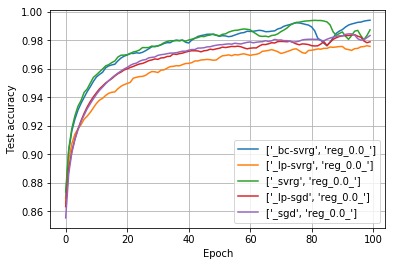

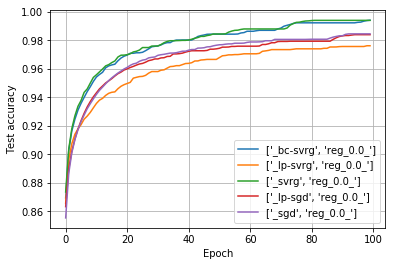

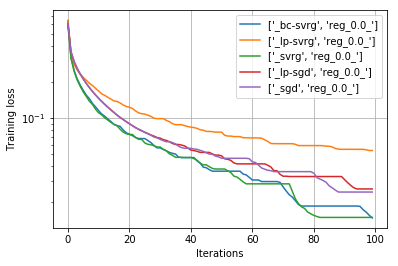

In [12]:
best_test_acc_list, best_train_loss_list, plot_label_list = \
plot_best_config_fixed_epochs(top_directory = "/dfs/scratch0/zjian/floating_halp/exp_res/lstm_dec_24_conll2000/",
                              cut_off_epoch=100, 
                              total_epoch=100, 
                              win_width=100, 
                              epoch_len=558,
                              seed_list=[1, 2, 3],
                              pattern_list_array=[ ["_bc-svrg", "reg_0.0_"],
                                                      ["_lp-svrg", "reg_0.0_"],
                                                      ["_svrg", "reg_0.0_"],
                                                      ["_lp-sgd", "reg_0.0_"],
                                                      ["_sgd", "reg_0.0_"]])



['_bc-svrg']
best test acc and config  0.9941624429482815 99 opt_bc-svrg_momentum_0.9_lr_0.5_l2_reg_0.0_


/home/ubuntu/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


best train loss and config  0.014777310575350781 99 opt_bc-svrg_momentum_0.9_lr_0.5_l2_reg_0.0_


['_lp-svrg']
best test acc and config  0.9762604962553899 98 opt_lp-svrg_momentum_0.9_lr_0.5_l2_reg_0.0_
best train loss and config  0.05371080077249944 98 opt_lp-svrg_momentum_0.9_lr_0.5_l2_reg_0.0_


['_svrg']
best test acc and config  0.9940836422321406 81 opt_svrg_momentum_0.0_lr_5.0_l2_reg_0.0_
best train loss and config  0.014917608556710964 82 opt_svrg_momentum_0.0_lr_5.0_l2_reg_0.0_


['_lp-sgd']
best test acc and config  0.9840286708525608 94 opt_lp-sgd_momentum_0.0_lr_5.0_l2_reg_0.0_
best train loss and config  0.025728746981603698 94 opt_lp-sgd_momentum_0.0_lr_5.0_l2_reg_0.0_


['_sgd']
best test acc and config  0.9846117961520034 93 opt_sgd_momentum_0.9_lr_0.5_l2_reg_0.0_
best train loss and config  0.024252920465353597 88 opt_sgd_momentum_0.0_lr_5.0_l2_reg_0.0_


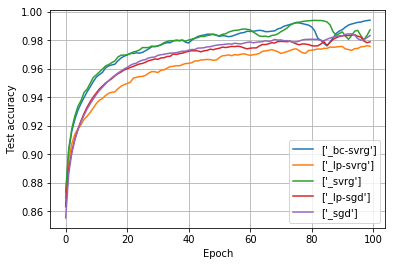

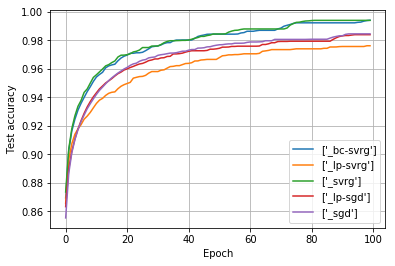

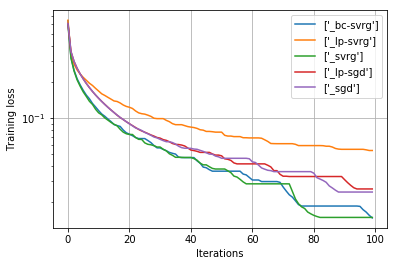

In [21]:
best_test_acc_list, best_train_loss_list, plot_label_list = \
plot_best_config_fixed_epochs(top_directory = "/dfs/scratch0/zjian/floating_halp/exp_res/lstm_dec_24_conll2000/",
                              cut_off_epoch=100, 
                              total_epoch=100, 
                              win_width=100, 
                              epoch_len=558,
                              seed_list=[1, 2, 3],
                              pattern_list_array=[ ["_bc-svrg"],
                                                      ["_lp-svrg"],
                                                      ["_svrg"],
                                                      ["_lp-sgd"],
                                                      ["_sgd"]])

In [32]:
# save_list = ["halp", "svrg (16)", "svrg (32)", "sgd (16)", "sgd (32)"]

In [35]:
plot_label_list=["halp", "svrg (16)", "svrg (32)", "sgd (16)", "sgd (32)"]

In [36]:
data_list = [(name, np.arange(y.size) + 1, np.maximum.accumulate(y)) \
             for name, y in zip(plot_label_list, best_test_acc_list) \
            if name in save_list ]
save_csv_only_y(data_list, 
         file_name="./data/lstm_test_acc_all.csv")
data_list = [(name, np.arange(y.size) + 1, np.minimum.accumulate(y) ) \
             for name, y in zip(plot_label_list, best_train_loss_list) \
             if name in save_list ]
save_csv_only_y(data_list, 
         file_name="./data/lstm_train_loss_all.csv")

In [30]:
print(len(data_list), len(best_test_acc_list), len(best_train_loss_list))
print(plot_label_list)

4 5 5
['halp', 'svrg (16)', 'svrg (32)', 'bc-sgd (16)', 'sgd (16)', 'sgd (32)']
